In [ ]:
# General Imports
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from tabulate import tabulate

# Sklearn Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [ ]:
# Implementation of the Gated Recurrent Unit
class GRU():

  def __init__(self, dataset):
    # Load and preprocess the data from the given link (to a GitHub repo file)
    self.market_data = pd.read_parquet(dataset)
    self.preprocess_data()

    # Set the divisor values from https://ycharts.com/indicators/sp_500_divisor#:~:text=S%26P%20500%20Divisor%20is%20at,0.23%25%20from%20one%20year%20ago
    # The divisor is used to calculate the S&P 500 Index based on the total
    # market cap for the given quarter and is in the millions
    self.divisors = {2013: {'Q1': 8934.61, 'Q2': 8908.33, 'Q3': 8908.77, 'Q4': 8896.86},
                     2014: {'Q1': 8924.03, 'Q2': 8919.22, 'Q3': 8878.54, 'Q4': 8882.35},
                     2015: {'Q1': 8861.60, 'Q2': 8851.25, 'Q3': 8830.99, 'Q4': 8810.57},
                     2016: {'Q1': 8757.39, 'Q2': 8718.72, 'Q3': 8667.94, 'Q4': 8643.59},
                     2017: {'Q1': 8606.26, 'Q2': 8581.63, 'Q3': 8567.30, 'Q4': 8565.26},
                     2018: {'Q1': 8535.74, 'Q2': 8518.41, 'Q3': 8474.31, 'Q4': 8434.96}}
    self.extract_index_data()

  # Preprocess the given dataset
  def preprocess_data(self):
    # Drop all unnecessary columns
    # We will only need the date, closing price, and volume
    self.market_data.drop(columns=['open', 'high', 'low', 'Name'], inplace=True)
    column_names = self.market_data.columns

    # Remove all rows with empty or missing values
    self.market_data.dropna(inplace=True)

    # Drop any duplicate rows
    self.market_data.drop_duplicates(inplace=True)

    # Convert the date column to datetime format
    self.market_data['date'] = pd.to_datetime(self.market_data['date'], format='%Y-%m-%d')

  # Calculate the S&P 500 Index using the closing price for every day
  def extract_index_data(self):
    # Calculate the numerator to calculate the Index and group by the date
    self.market_data['index_numerator'] = self.market_data['close'] * self.market_data['volume']
    self.market_data.drop(columns=['close', 'volume'], inplace=True)
    self.index_data = self.market_data.groupby(['date']).sum().reset_index()

    # Apply the appropriate divisor based on the quarter
    def apply_divisor(row):
      # Q1 for January-March
      if row['date'].month in [1,2,3]:
        quarter = 'Q1'
      # Q2 for April-June
      elif row['date'].month in [4,5,6]:
        quarter = 'Q2'
      # Q3 for July-September
      elif row['date'].month in [7,8,9]:
        quarter = 'Q3'
      # Q4 for October-December
      else:
        quarter = 'Q4'
      return float(row['index_numerator']) / (self.divisors[row['date'].year][quarter] * 1e4)

    # Apply the divisor for every date's numerator
    self.index_data['index'] = self.index_data.apply(apply_divisor, axis=1)




In [ ]:
gru = GRU('https://github.com/nikhilmanda9/ML-Stock-Market-Prediction/blob/main/all_stocks_5yr.parquet?raw=true')
gru.index_data.head()

,date,index_numerator,index
0,2013-02-08,9.098417e+10,1018.333939
1,2013-02-11,7.981175e+10,893.287441
2,2013-02-12,9.551958e+10,1069.096202
3,2013-02-13,9.444358e+10,1057.053194
4,2013-02-14,1.034860e+11,1158.259827


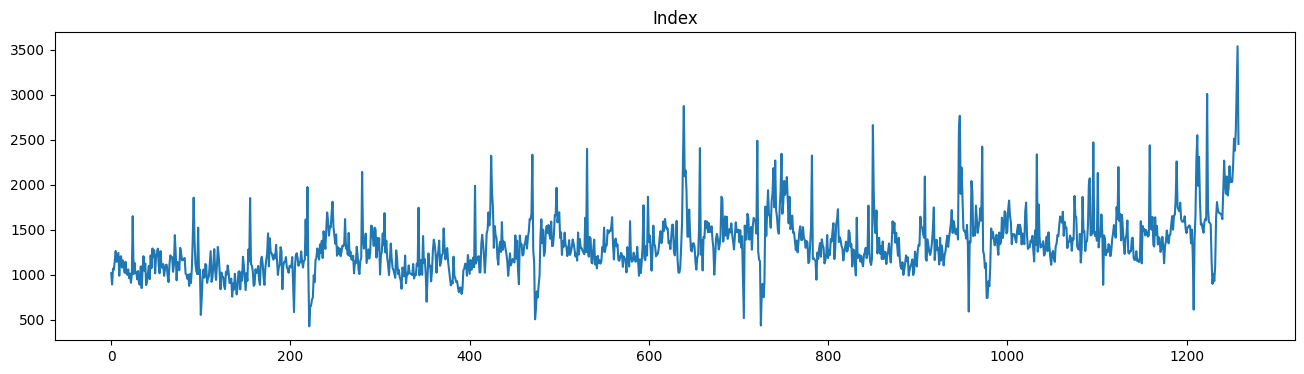

In [ ]:
# visualization of "High" attribute of the dataset

gru.index_data["index"].plot(figsize=(16,4))
plt.title("Index")
plt.show()